# Modeling  Regression for GHI Prediction
This notebook trains, tunes and evaluates regression models to predict Global Horizontal Irradiance (GHI).
It implements multiple split strategies, outlier detection, model training (Linear, KNN, SVR, RandomForest, XGBoost, LightGBM),
evaluation (MSE, RMSE, R²), interpretability and grid-search hyperparameter tuning.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Imports

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, IsolationForest


from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

## 2. Load processed data

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Solar-Radiation-Prediction/data/solar_processed.csv")
df.head()

,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,...,Precipitation,TModA,TModB,Country,Hour,Day,Month,DayOfYear,WSgust_ratio,HeatIndex
0,-0.709061,-0.591499,-0.735635,-0.707273,-0.706761,-0.237176,1.065620,-1.222658,-1.109872,-1.256832,...,-0.070923,-0.549845,-0.538336,0,0,9,8,221,7.174465,1.176506
1,-0.708746,-0.591499,-0.735635,-0.707273,-0.706761,-0.237176,1.072626,-1.222658,-1.313821,-1.601184,...,-0.070923,-0.549845,-0.538336,0,0,9,8,221,-0.123320,1.184266
2,-0.708746,-0.591499,-0.735635,-0.707273,-0.706761,-0.237176,1.076130,-1.027391,-0.752961,0.120578,...,-0.070923,-0.542098,-0.538336,0,0,9,8,221,-0.056645,1.188146
3,-0.708746,-0.591091,-0.735003,-0.707273,-0.706761,-0.237176,1.062116,-1.092480,-0.956910,-0.223774,...,-0.070923,-0.542098,-0.530264,0,0,9,8,221,-0.059782,1.172626
4,-0.708432,-0.591091,-0.735003,-0.707273,-0.706761,-0.237176,1.062116,-1.157569,-0.956910,-0.568127,...,-0.070923,-0.542098,-0.530264,0,0,9,8,221,0.003127,1.172626


## 3. Outlier Detection (Isolation Forest)

In [4]:
iso = IsolationForest(contamination=0.02, random_state=42)

# Only numeric columns
X = df.select_dtypes(include='number')

df["outlier_iso"] = iso.fit_predict(X)

df_clean = df[df["outlier_iso"] == 1].drop(columns=["outlier_iso"])

print("Original size:", df.shape)
print("Cleaned size:", df_clean.shape)

Original size: (1576800, 23)
Cleaned size: (1545264, 22)


## 4. Train/Val/Test Split Experiment

In [5]:
splits = [
    (0.7, 0.15, 0.15),
    (0.75, 0.1, 0.15),
    (0.8, 0.1, 0.1)
]

split_results = {}

X = df_clean.drop(columns=["GHI"])
y = df_clean["GHI"]

for train_ratio, val_ratio, test_ratio in splits:
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1-train_ratio), random_state=42)
    val_size = test_ratio / (val_ratio + test_ratio)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size, random_state=42)

    split_results[f"{train_ratio}/{val_ratio}/{test_ratio}"] = (
        X_train.shape[0],
        X_val.shape[0],
        X_test.shape[0]
    )

pd.DataFrame(split_results, index=["Train","Val","Test"])

,0.7/0.15/0.15,0.75/0.1/0.15,0.8/0.1/0.1
Train,1081684,1158948,1236211
Val,231790,154526,154526
Test,231790,231790,154527


## 5. Final Split

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)

## 6. Define Models Stack

In [7]:
models = {
    "LinearRegression": LinearRegression(),
    "KNN": KNeighborsRegressor(),
    "RandomForest": RandomForestRegressor(n_estimators=200, max_depth=15),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=8),
    "LightGBM": LGBMRegressor(n_estimators=300, learning_rate=0.05)
}

## 7. Evaluation Function

In [8]:
def evaluate(model, X, y):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, preds)
    return mse, rmse, r2


## 8. Train & Evaluate All Models

In [9]:
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    mse, rmse, r2 = evaluate(model, X_val, y_val)
    results[name] = {"MSE": mse, "RMSE": rmse, "R2": r2}

results_df = pd.DataFrame(results).T
results_df


Training LinearRegression...
Training KNN...
Training RandomForest...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3454
[LightGBM] [Info] Number of data points in the train set: 1158948, number of used features: 21
[LightGBM] [Info] Start training from score -0.038708


,MSE,RMSE,R2
LinearRegression,0.005167,0.071881,0.994475
KNN,0.003999,0.063235,0.995724
RandomForest,0.000276,0.016603,0.999705
XGBoost,0.000194,0.013926,0.999793
LightGBM,0.000342,0.018493,0.999634


## 9. Plot RMSE Comparison

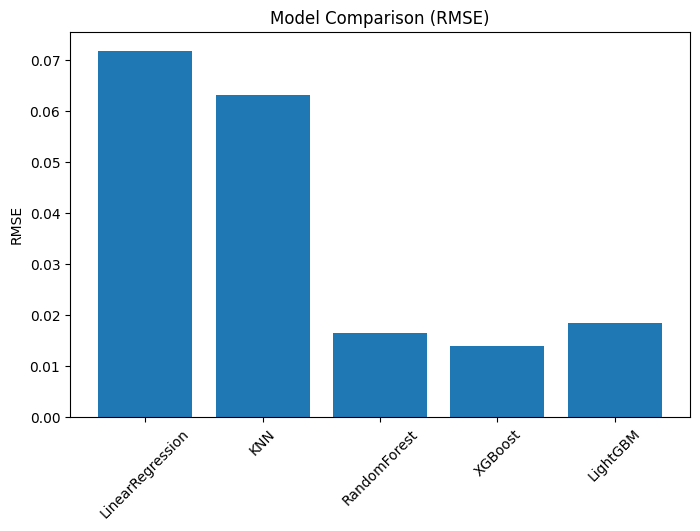

In [10]:
plt.figure(figsize=(8,5))
plt.bar(results_df.index, results_df["RMSE"])
plt.xticks(rotation=45)
plt.title("Model Comparison (RMSE)")
plt.ylabel("RMSE")
plt.show()

## 10. Feature Importance

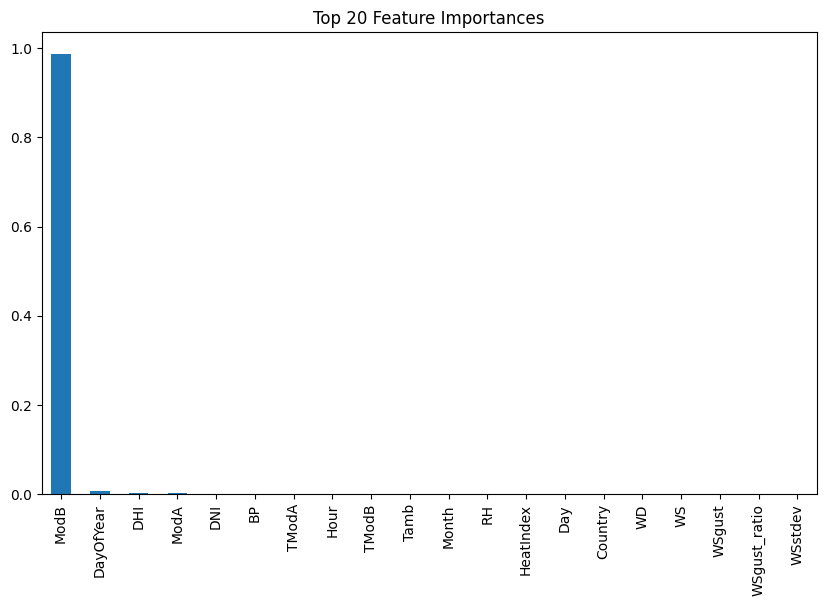

In [20]:
best_tree = models["RandomForest"]

importances = best_tree.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_imp.head(20).plot(kind="bar")
plt.title("Top 20 Feature Importances")
plt.show()

## 11. Predicted vs Actual Plot

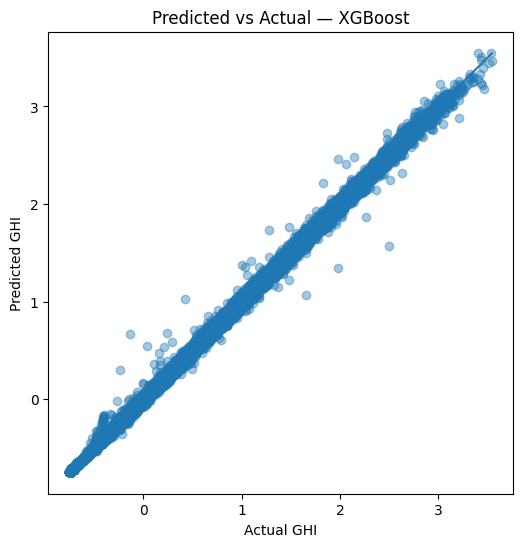

In [12]:
best_model_name = results_df["RMSE"].idxmin()
best_model = models[best_model_name]

preds = best_model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, preds, alpha=0.4)
plt.xlabel("Actual GHI")
plt.ylabel("Predicted GHI")
plt.title(f"Predicted vs Actual — {best_model_name}")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.show()

## 12. Grid Search Tuning

In [15]:
param_grids = {
    "XGBoost": {
        "max_depth": [6, 8, 10],
        "learning_rate": [0.05, 0.1]
    },
    "LightGBM": {
        "num_leaves": [31, 50],
        "learning_rate": [0.05, 0.1]
    }
}

tuned_models = {}

for name, params in param_grids.items():
    print(f"Tuning {name}...")

    model = models[name]
    grid = GridSearchCV(
        model,
        params,
        cv=3,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    tuned_models[name] = grid.best_estimator_

    print(f"Best params for {name}: {grid.best_params_}")



Tuning XGBoost...
Best params for XGBoost: {'learning_rate': 0.1, 'max_depth': 10}
Tuning LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3454
[LightGBM] [Info] Number of data points in the train set: 1158948, number of used features: 21
[LightGBM] [Info] Start training from score -0.038708
Best params for LightGBM: {'learning_rate': 0.1, 'num_leaves': 50}


## 13. Save Best Model

In [17]:
best_model_name = results_df["RMSE"].idxmin()

if best_model_name in tuned_models:
    final_best = tuned_models[best_model_name]
else:
    final_best = models[best_model_name]

joblib.dump(final_best, "/content/drive/MyDrive/Solar-Radiation-Prediction/models/best_model.pkl")
print("Saved final best model!")


Saved final best model!
